# Part I

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

%matplotlib inline

In [2]:
def dimensions(box, size=None):
    if box is None:
        if size is not None:
            return np.zeros(size)
        else: 
            raise ValueError('If box is not provided, you must specify size.')
            
    return np.diff(box, axis=1).flatten()

def linear_dimension(box):
    if box is None:
        return 0
    return dimensions(box).sum()

def interval_difference(outer_interval, inner_interval):
    lower_outer, upper_outer = outer_interval
    lower_inner, upper_inner = inner_interval
    return [lower_outer, lower_inner], [upper_inner, upper_outer]

def sample_interval_difference(outer_interval, inner_interval):
    intervals = interval_difference(outer_interval, inner_interval)
    dimensions = [np.diff(intervals[0])[0], np.diff(intervals[1])[0]]
    chosen_interval_index = np.random.choice(range(len(intervals)), p=dimensions/np.sum(dimensions))
    chosen_interval = intervals[chosen_interval_index]
    return np.random.uniform(low=chosen_interval[0], high=chosen_interval[1], size=1)[0], chosen_interval_index

def random_axis(dimensions):
    return np.random.choice(range(len(dimensions)), 
                            p=dimensions/np.sum(dimensions))

def random_cut(box, axis):
    return np.random.uniform(low=self.box[axis][0], 
                             high=self.box[axis][1], 
                             size=1)[0]

def cost_next_cut(linear_dimension):
    return np.random.exponential(scale=1.0/linear_dimension, size=1)[0]

def new_cut_proposal(self):
    cost = self.cost_next_cut()
    axis = self.random_axis()
    cut_point = self.random_cut(axis)
    return cost, axis, cut_point

def cut_boxes(box, cut_axis, cut_point):
    left = box.copy()
    right = box.copy()
    low, high = box[cut_axis]

    if cut_point <= low or cut_point >= high:
        raise ValueError('Point is not in interval.')

    left[cut_axis] = [low, cut_point]
    right[cut_axis] = [cut_point, high]
    return left, right

In [3]:
class Mondrian(object):
    def __init__(self, box, budget):
        self.box = box
        self.budget = budget
        self.cut_point = None
        self.cut_axis = None
        self.cut_budget = None
        self.left = None
        self.right = None
        
    def extended_by(self, box):
        if self.box is None:
            return True
        return all((box[:, 0] <= self.box[:, 0]) & (box[:, 1] >= self.box[:, 1]))
    
    def contains(self, point):
        if self.box is None:
            return False
        return all(box[:,0] <= point) & (box[:,1] >= point)
    
    def has_cut(self):
        return self.cut_axis is not None
    
    def is_empty(self):
        return self.box is None
    
def grow_mondrian(box, budget, given_mondrian=None):
    if given_mondrian is None:
        given_mondrian = Mondrian(None, budget)

    if not given_mondrian.extended_by(box):
        raise ValueError('Incompatible boxes: given mondrian box must be contained in new box.')
    
    mondrian = Mondrian(box, budget)
    
    cost = cost_next_cut(linear_dimension(box) - linear_dimension(given_mondrian.box))
    
    next_budget = budget - cost
    
    given_mondrian_next_budget = given_mondrian.cut_budget if given_mondrian.has_cut() else 0
    
    
    if next_budget < given_mondrian_next_budget:        
        if given_mondrian.has_cut():
            mondrian.cut_axis = given_mondrian.cut_axis
            mondrian.cut_point = given_mondrian.cut_point
            mondrian.cut_budget = given_mondrian_next_budget

            left, right = cut_boxes(box, mondrian.cut_axis, mondrian.cut_point)

            mondrian.left = grow_mondrian(left, given_mondrian_next_budget, given_mondrian.left)
            mondrian.right = grow_mondrian(right, given_mondrian_next_budget, given_mondrian.right)
    else:
        dimensions_outer = dimensions(box)
        dimensions_inner = dimensions(given_mondrian.box, size=len(box))
        mondrian.cut_axis = random_axis(dimensions_outer - dimensions_inner)
        outer_interval = box[mondrian.cut_axis]
        
        if given_mondrian.is_empty():
            inner_interval = [outer_interval[0], outer_interval[0]]
        else:
            inner_interval = given_mondrian.box[mondrian.cut_axis]

        mondrian.cut_point, cut_side = sample_interval_difference(outer_interval, inner_interval)
        mondrian.cut_budget = next_budget
        
        left, right = cut_boxes(box, mondrian.cut_axis, mondrian.cut_point)

        if cut_side: # entire given_mondrian to the left
            mondrian.left = grow_mondrian(left, next_budget, given_mondrian)
            mondrian.right = grow_mondrian(right, next_budget, Mondrian(None, next_budget))
        else: # all given_mondrian to the right
            mondrian.left = grow_mondrian(left, next_budget, Mondrian(None, next_budget))
            mondrian.right = grow_mondrian(right, next_budget, given_mondrian)
            
    return mondrian

In [4]:
def get_random_color():
    return np.random.choice(['blue', 'red', 'yellow', 'white'], 1)[0]
    
def box_2d(box, color=None, alpha=None):
    low_x, high_x = box[0]
    low_y, high_y = box[1]
    width = high_x - low_x
    height = high_y - low_y
    
    if color is None:
        color = 'white'
    if alpha is None:
        alpha = 1
        
    lower_left_corner = np.array([low_x, low_y])
    
    return mpatches.Rectangle(lower_left_corner, width, height, 
                              color=color, ec='black', linewidth=2, 
                              alpha=alpha)

def boxes(m, box_collection, color=None):
    random_color = False
    
    if color == 'true_mondrian':
        random_color = True
        color = get_random_color()
    
    box_collection.append(box_2d(m.box, color))
    
    if m.has_cut():
        color = 'true_mondrian' if random_color else color
        boxes(m.left, box_collection, color)
        boxes(m.right, box_collection, color)
        
def plot_coloured_mondrian(m, ax, color=None, given_mondrian=None):
    if given_mondrian is None:
        given_mondrian = Mondrian(None, budget)
        
    box_collection = []
    boxes(m, box_collection, color)
    
    if not given_mondrian.is_empty():
        box_collection.append(box_2d(given_mondrian.box, 
                                     color='black', alpha=0.1))
        
    collection = PatchCollection(box_collection, match_original=True)
    ax.add_collection(collection)
    
    ax.axis('off')
    ax.autoscale()
    #plt.show()
    
def random_mondrians(box, budget, given_mondrian=None, color=None, rows=1, columns=1, figsize=(15, 15)):
    if given_mondrian is None:
        given_mondrian = Mondrian(None, budget)
        
    if rows == 1 and columns == 1:
        fig, ax = plt.subplots(figsize=figsize)  
        plot_coloured_mondrian(grow_mondrian(box, budget, given_mondrian), 
                               ax, color=color, given_mondrian=given_mondrian)
    else:
        fig, ax = plt.subplots(rows, columns, figsize=figsize)  

        for row in range(rows):
            for col in range(columns):
                if not given_mondrian.is_empty() and row == 0 and col ==0:
                    plot_coloured_mondrian(given_mondrian, ax[row, col], color=color)
                else:
                    plot_coloured_mondrian(grow_mondrian(box, budget, given_mondrian), 
                                           ax[row, col], color=color, given_mondrian=given_mondrian)
                    
def growing_mondrians(initial_box, budget, rows=1, columns=1, figsize=(15, 15)):
    if rows == 1 and columns == 1:
        fig, ax = plt.subplots(figsize=figsize)  
        plot_coloured_mondrian(grow_mondrian(box, budget), 
                               ax, color=None)
    else:
        fig, ax = plt.subplots(rows, columns, figsize=figsize)  
        
        given_mondrian = Mondrian(None, budget)
        box = initial_box
        for row in range(rows):
            for col in range(columns):
                mondrian = grow_mondrian(box, budget, given_mondrian)
                plot_coloured_mondrian(mondrian, ax[row, col], color=None, given_mondrian=given_mondrian)
                given_mondrian = mondrian
                box = 2 * box

In [5]:
box = np.array([[0.0, 1.0], [0.0, 1.0]])

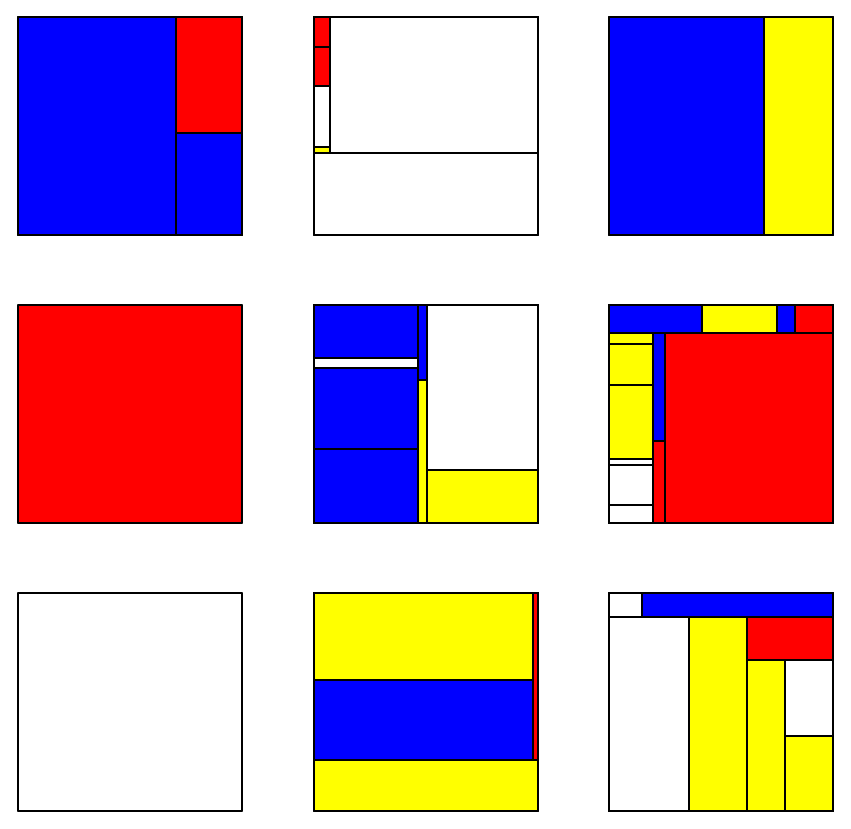

In [7]:
random_mondrians(box, 1, rows=3, columns=3, color='true_mondrian')
plt.savefig("MondrianExmpl.pdf")

---
# Part II:

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
sns.set_palette("colorblind")
import sklearn.datasets 
from sklearn.model_selection import train_test_split
import skgarden
from skgarden import MondrianForestClassifier
from skgarden import MondrianForestRegressor
from skgarden import MondrianTreeClassifier
from skgarden import MondrianTreeRegressor
from sklearn.linear_model import LinearRegression
import sklearn

C:\Users\Walid\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Walid\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Walid\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be remo

In [13]:
from sklearn.datasets import load_boston

In [14]:
boston = load_boston()

In [15]:
df_x=pd.DataFrame(boston.data, columns=boston.feature_names)
df_y=pd.DataFrame(boston.target)

In [16]:
df_x.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


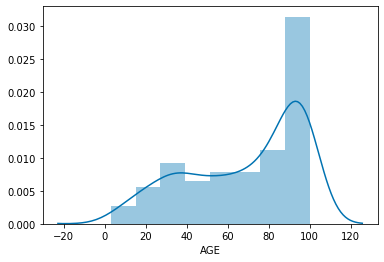

In [17]:
sns.distplot(df_x.AGE)
plt.savefig("Age.pdf") 

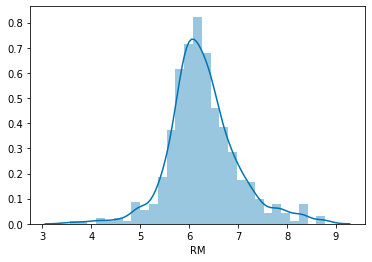

In [18]:
sns.distplot(df_x.RM)
plt.savefig("RM.pdf") 

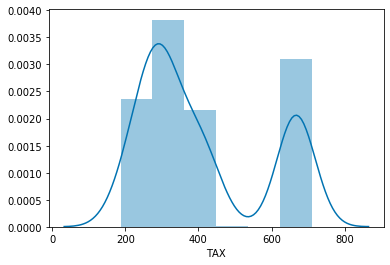

In [19]:
sns.distplot(df_x.TAX)
plt.savefig("TAX.pdf") 

In [20]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
# Mondrian Tree Regressor
mtr = MondrianForestRegressor()
mtr.fit(X, y)
y_mean, y_std = mtr.predict(X, return_std=True)
mtr.fit(X, y)